In [ ]:
!pip install -q datasets transformers accelerate scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 70.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 48.8 MB/s eta 0:00:00


# 1. INSTALACIÓN E IMPORTACIONES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import torch

# 2. CARGA Y PREPARACIÓN DE DATOS

## Carga de datos

In [ ]:
train_url = "https://huggingface.co/api/datasets/fancyzhx/ag_news/parquet/default/train/0.parquet"
test_url = "https://huggingface.co/api/datasets/fancyzhx/ag_news/parquet/default/test/0.parquet"

train_df = pd.read_parquet(train_url)
test_df = pd.read_parquet(test_url)

# Use subset for faster training
train_df = train_df.sample(n=20000, random_state=42).reset_index(drop=True)
test_df = test_df.sample(n=3000, random_state=42).reset_index(drop=True)

print(f"✅ Loaded: {len(train_df)} train, {len(test_df)} test examples")


✅ Loaded: 20000 train, 3000 test examples


## SPLIT DATA: 70% train, 15% val, 15% test

In [ ]:
print("\n✂️ Splitting data...")

# Split train into train (70%) and temp (30%)
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42, stratify=train_df['label'])

# Split temp into validation (15%) and test (15%)
val_data, test_data = train_test_split(test_df, test_size=0.5, random_state=42, stratify=test_df['label'])

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# Convert to HuggingFace Dataset format
train_dataset = Dataset.from_pandas(train_data[['text', 'label']])
val_dataset = Dataset.from_pandas(val_data[['text', 'label']])
test_dataset = Dataset.from_pandas(test_data[['text', 'label']])



✂️ Splitting data...
Train: 14000, Validation: 1500, Test: 1500


# Funciones

In [ ]:
def tokenize_function(examples, tokenizer):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=128)


In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {'accuracy': acc, 'f1': f1, 'precision': precision, 'recall': recall}


In [ ]:
def train_model(model_name, train_ds, val_ds, test_ds):
    print(f"\n{'='*70}")
    print(f"Training: {model_name}")
    print(f"{'='*70}")

    # Load tokenizer and tokenize datasets
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    train_tokenized = train_ds.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    val_tokenized = val_ds.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    test_tokenized = test_ds.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

    # Training arguments
    args = TrainingArguments(
        output_dir=f'./results/{model_name.split("/")[-1]}',
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        logging_steps=50,
        fp16=torch.cuda.is_available(),
        report_to="none",
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tokenized,
        eval_dataset=val_tokenized,
        compute_metrics=compute_metrics,
    )

    # Train
    trainer.train()

    # Evaluate on test set
    results = trainer.evaluate(test_tokenized)

    print(f"\n✅ Results on test set:")
    print(f"   Accuracy:  {results['eval_accuracy']:.4f}")
    print(f"   F1-Score:  {results['eval_f1']:.4f}")
    print(f"   Precision: {results['eval_precision']:.4f}")
    print(f"   Recall:    {results['eval_recall']:.4f}")

    del trainer, model, tokenizer
    torch.cuda.empty_cache()

    return results

# TRAIN ALL MODELS

In [ ]:
models = {
    'RoBERTa': 'roberta-base',
    'DeBERTa': 'microsoft/deberta-v3-base',
    'ModernBERT': 'answerdotai/ModernBERT-base'
}

results = {}

for name, model_path in models.items():
    result = train_model(model_path, train_dataset, val_dataset, test_dataset)
    results[name] = {
        'accuracy': result['eval_accuracy'],
        'f1': result['eval_f1'],
        'precision': result['eval_precision'],
        'recall': result['eval_recall']
    }



Training: roberta-base


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.290000,0.258580,0.913333,0.913107,0.916695,0.913333
2,0.174000,0.253645,0.924667,0.924580,0.924681,0.924667



✅ Results on test set:
   Accuracy:  0.9367
   F1-Score:  0.9365
   Precision: 0.9365
   Recall:    0.9367

Training: microsoft/deberta-v3-base


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.295300,0.277278,0.914000,0.914144,0.917164,0.914000
2,0.177300,0.230530,0.930667,0.930730,0.931092,0.930667



✅ Results on test set:
   Accuracy:  0.9300
   F1-Score:  0.9298
   Precision: 0.9297
   Recall:    0.9300

Training: answerdotai/ModernBERT-base


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/14000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W1024 05:07:44.063000 320 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.179700,0.204486,0.925333,0.925347,0.925567,0.925333
2,0.070800,0.223156,0.938667,0.938671,0.938747,0.938667



✅ Results on test set:
   Accuracy:  0.9367
   F1-Score:  0.9365
   Precision: 0.9366
   Recall:    0.9367


## VISUALIZE RESULTS

In [ ]:
print("\n" + "="*70)
print("FINAL COMPARISON")
print("="*70)

model_names = list(results.keys())
f1_scores = [results[m]['f1'] for m in model_names]
accuracies = [results[m]['accuracy'] for m in model_names]
precisions = [results[m]['precision'] for m in model_names]
recalls = [results[m]['recall'] for m in model_names]


FINAL COMPARISON


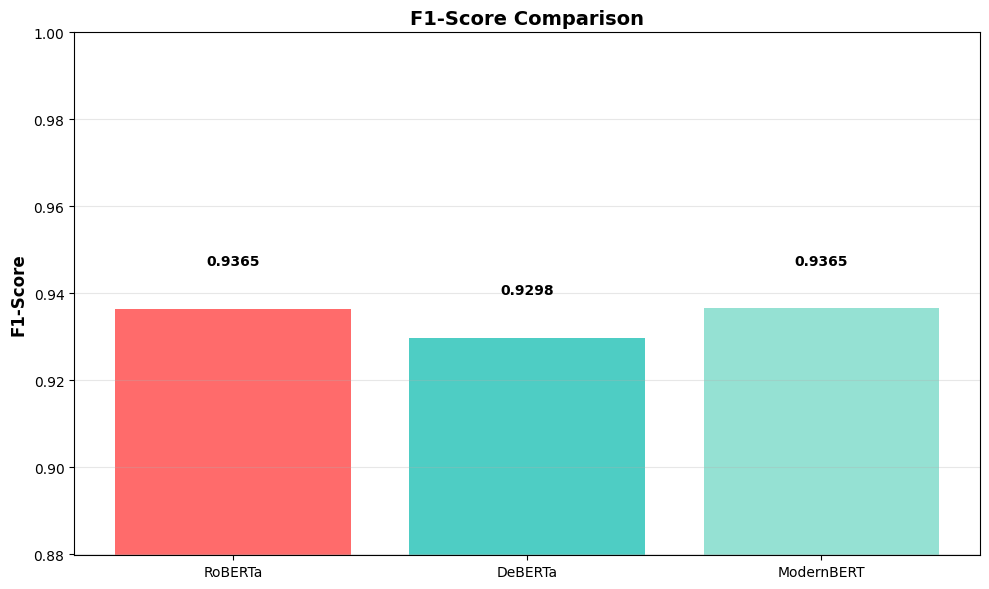

In [ ]:
# Plot 1: F1-Score comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, f1_scores, color=['#FF6B6B', '#4ECDC4', '#95E1D3'])
plt.ylabel('F1-Score', fontsize=12, fontweight='bold')
plt.title('F1-Score Comparison', fontsize=14, fontweight='bold')
plt.ylim([min(f1_scores) - 0.05, 1.0])
plt.grid(axis='y', alpha=0.3)

for i, v in enumerate(f1_scores):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig('F1_metrics.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

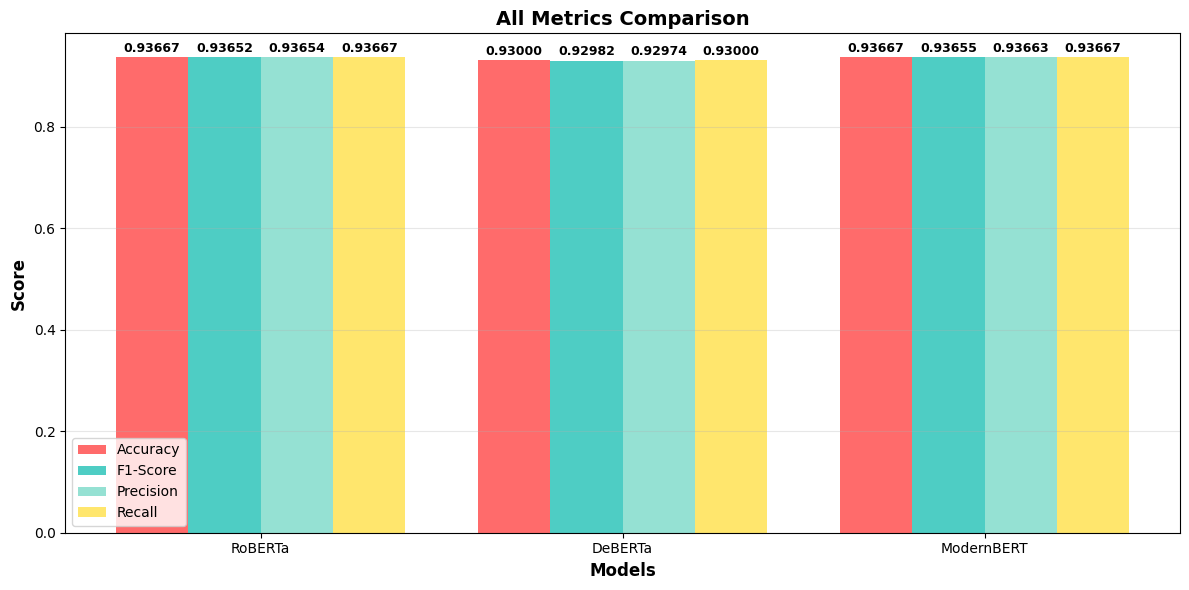

In [ ]:
# Plot 2: All metrics comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.2

bars1 = ax.bar(x - 1.5*width, accuracies, width, label='Accuracy', color='#FF6B6B')
bars2 = ax.bar(x - 0.5*width, f1_scores, width, label='F1-Score', color='#4ECDC4')
bars3 = ax.bar(x + 0.5*width, precisions, width, label='Precision', color='#95E1D3')
bars4 = ax.bar(x + 1.5*width, recalls, width, label='Recall', color='#FFE66D')

# Add values on top of bars
for bars, values in [(bars1, accuracies), (bars2, f1_scores), (bars3, precisions), (bars4, recalls)]:
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.5f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
plt.savefig('all_metrics.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

In [ ]:
# Print table
print("\n📊 RESULTS TABLE:")
print("-" * 70)
print(f"{'Model':<15} {'Accuracy':<12} {'F1-Score':<12} {'Precision':<12} {'Recall':<12}")
print("-" * 70)
for model in model_names:
    print(f"{model:<15} {results[model]['accuracy']:<12.4f} {results[model]['f1']:<12.4f} "
          f"{results[model]['precision']:<12.4f} {results[model]['recall']:<12.4f}")
print("-" * 70)

best = max(results.items(), key=lambda x: x[1]['f1'])
print(f"\n🏆 BEST MODEL: {best[0]} (F1-Score: {best[1]['f1']:.4f})")
print("\n✅ Done!")


📊 RESULTS TABLE:
----------------------------------------------------------------------
Model           Accuracy     F1-Score     Precision    Recall      
----------------------------------------------------------------------
RoBERTa         0.9367       0.9365       0.9365       0.9367      
DeBERTa         0.9300       0.9298       0.9297       0.9300      
ModernBERT      0.9367       0.9365       0.9366       0.9367      
----------------------------------------------------------------------

🏆 BEST MODEL: ModernBERT (F1-Score: 0.9365)

✅ Done!
